Предположим, что нам даны два набора наблюдений, красные и синие точки, которые описываются двумя разными [нормальными распределениями](https://en.wikipedia.org/wiki/Normal_distribution). Наша цель - найти среднее и стандартное отклонение для каждого набора точек.

In [37]:
# генерация наблюдений
import numpy as np

np.random.seed(42)

red_mean = 40
red_std = 20

blue_mean = 80
blue_std = 13

green_mean = 60 # добавляем зеленые точки
green_std = 10 # добавляем зеленые точки

red = np.random.normal(red_mean, red_std, size=40)
blue = np.random.normal(blue_mean, blue_std, size=40)
green = np.random.normal(green_mean, green_std, size=40)

both_colours = np.sort(np.concatenate((red, blue, green)))

Давайте их отобразим:

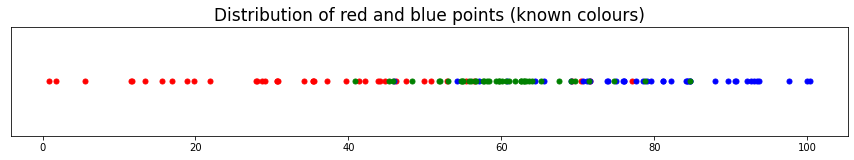

In [38]:
%matplotlib inline

import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = (15, 2)

plt.plot(red, np.zeros_like(red), '.', color='r', markersize=10);
plt.plot(blue, np.zeros_like(blue), '.', color='b', markersize=10);
plt.plot(green, np.zeros_like(green), '.', color='g', markersize=10);
plt.title(r'Distribution of red and blue points (known colours)', fontsize=17);
plt.yticks([]);

Мы видим цвет каждого наблюдения (точки), поэтому легко можем вычислить характеристики каждого распределения:

In [39]:
print(np.mean(red), np.std(red))
print(np.mean(blue), np.std(blue))
print(np.mean(green), np.std(green))

35.62726323164121 18.816469710458275
79.62243495704179 12.384211983757545
60.10173138092917 8.512495937035805


## Забываем цвета

Но обычно мы имеем дело вот с такой картиной:

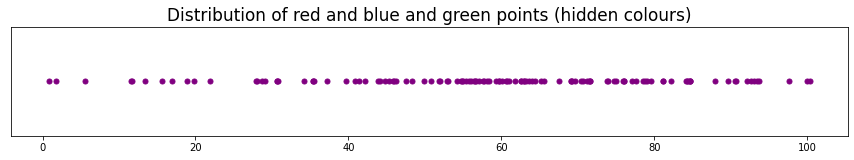

In [40]:
plt.rcParams['figure.figsize'] = (15, 2)

plt.plot(both_colours, np.zeros_like(both_colours), '.', color='purple', markersize=10);
plt.title(r'Distribution of red and blue and green points (hidden colours)', fontsize=17);
plt.yticks([]);

Теперь у нас появились скрытые переменные.

Мы знаем, что каждая точка на самом деле либо красная, либо синяя, но реальный цвет нам неизвестен. Таким образом, мы не знаем, как определить характеристики каждого распределения.

Как мы можем теперь оценить наиболее вероятные значения среднего и стандартного отклонения каждой группы?

Мы будем использовать **Expectation Maximisation**, чтобы найти наилучшие оценки для этих значений.

## Функция правдоподобия

Для начала нам нужна [функция правдоподобия](https://en.wikipedia.org/wiki/Likelihood_function). 
Максимизация ожидания заключается в нахождении параметров, при которых значения этой функции принимают как можно большие значения с учетом наших данных.

Нас интересует вероятность того, что параметры распределения, например, среднее и стандартное отклонение синих точек (обозначаем как $ B $), верны с учетом наблюдаемых данных (обозначенных $ x_i $). Это можно обозначить следующим образом:

$$p(B \mid x_i)$$

[Вспомним теорему Байеса](https://en.wikipedia.org/wiki/Bayes%27_theorem):

$$ p(B \mid x_i) = \frac{p(x_i \mid B)\cdot p(B)}{p(x_i)}$$

Отбросим вероятности каждого класса, так как считаем (а в нашем случае и знаем), что они равновероятны. Также отбросим константы, которые укладывают значения между 0 и 1.

Получится следующая функция правдоподобия, именно её и нужно максимизировать:

$$L(B \mid x_i) =  P(x_i \mid B)$$

Как посчитать вероятность на основе функции плотности вы прекрасно знаете. Для нормального распределения можно воспользоваться библиотечной функцией: 

``` python
stats.norm(mean, standard_deviation).pdf(x)
```

## Максимизация ожиданий

Мы знаем, что у нас есть две группы наблюдений, каждая из которых подчиняется нормальному распределению. У нас также есть функция правдоподобия, и мы хотели бы найти значения для среднего и стандартного отклонения, при которых значения функции правдоподобия становятся максимальными.

Наш подход будет следующим:


1. Начнинаем с первоначальных оценок среднего и стандартного отклонения для красной и синей групп (могут быть любыми).
2. С помощью функции правдоподобия проверяем правдоподобность оценки среднего и стандартного отклонения на группах точек.
3. Произведём взвешивание для каждых параметров (среднее значение, стандартное отклонение) для каждой точки из данных. Другими словами, чем больше вес, тем больше мы считаем, что точка была получена из распределения с этими параметрами. Эти веса позволят нам «перемасштабировать» точки данных вдоль оси (шаг **Expectation**).
4. Вычисляем новые оценки максимального правдоподобия каждого параметра на основе масштабированных точек данных (шаг **Maximisation**).
5. Повторяем шаги 2–4 до тех пор, пока оценка каждого параметра не сойдется или не будет достигнуто заданное количество итераций.

Функция для вычисления веса для каждой точки данных (параметры и значения являются NumPy массивами):

In [41]:
def weight_of_colour(colour_likelihood, total_likelihood):
    return colour_likelihood / total_likelihood

Функции для вычисления нового среднего и стандартного отклонения с использованием весов:

estimate_mean(data, weight)$=\frac{\sum(data_i \times weight_i)}{\sum weight_i}$


estimate_std(data, weight, mean)$=\sqrt\frac{\sum(weight_i *(data_i - mean)^2)}{\sum weight_i}$

In [42]:
def estimate_mean(data, weight):
  return sum(data[i]*weight[i] for i in range(0, len(data)))/sum(weight)

def estimate_std(data, weight, mean):
  return (sum(weight[i]*(data[i]-mean)**2 for i in range(0, len(data)))/sum(weight))**(1/2)

У нас нет информации о параметрах распределений, поэтому просто делаем предположения:

In [43]:
# Для среднего
red_mean_guess = 35
blue_mean_guess = 90
green_mean_guess = 55

# Для стандартного отклонения
red_std_guess = 20
blue_std_guess = 20
green_std_guess = 15

И опишем функцию для отображения данных и распределений

In [44]:
from scipy import stats


def plot_guesses(red_mean_guess, blue_mean_guess, green_mean_guess, red_std_guess, blue_std_guess, green_std_guess, alpha=1):
    plt.rcParams['figure.figsize'] = (15, 5)
    plt.plot(both_colours, np.zeros_like(both_colours), '.', color='purple', markersize=10)

    lo = np.floor(both_colours.min()) - 1
    hi = np.ceil(both_colours.max()) + 1
    x = np.linspace(lo, hi, 500)
    
    plt.plot(x, stats.norm(red_mean_guess, red_std_guess).pdf(x), color='r', alpha=alpha)
    plt.plot(x, stats.norm(blue_mean_guess, blue_std_guess).pdf(x), color='b', alpha=alpha)
    plt.plot(x, stats.norm(green_mean_guess, green_std_guess).pdf(x), color='g', alpha=alpha)
    
    r_height = stats.norm(red_mean_guess, red_std_guess).pdf(red_mean_guess)
    b_height = stats.norm(blue_mean_guess, blue_std_guess).pdf(blue_mean_guess)
    g_height = stats.norm(green_mean_guess, green_std_guess).pdf(green_mean_guess)
    
    
    plt.vlines(red_mean_guess, 0, r_height, 'r', '--', alpha=alpha)
    plt.vlines(blue_mean_guess, 0, b_height, 'b', '--', alpha=alpha)
    plt.vlines(green_mean_guess, 0, g_height, 'g', '--', alpha=alpha);

Давайте отрисуем наши предположения:

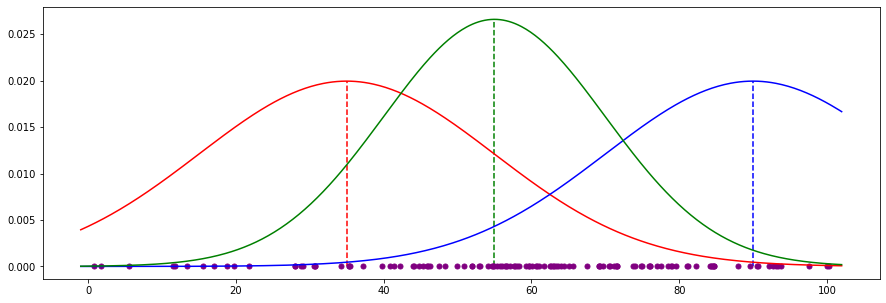

In [45]:
plot_guesses(red_mean_guess, blue_mean_guess, green_mean_guess, red_std_guess, blue_std_guess, green_std_guess)

Они далековаты от истины, поэтому запускаем EM алгоритм:

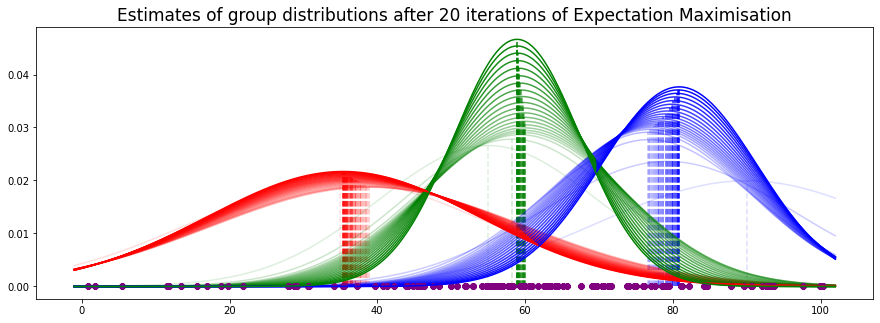

In [46]:
# estimates for the mean
red_mean_guess = 35
blue_mean_guess = 90
green_mean_guess = 55

# estimates for the standard deviation
red_std_guess = 20
blue_std_guess = 20
green_std_guess = 15

N_ITER = 20 # number of iterations of EM

alphas = np.linspace(0.2, 1, N_ITER) # transparency of curves to plot for each iteration

# plot initial estimates
plot_guesses(red_mean_guess, blue_mean_guess, green_mean_guess, red_std_guess, blue_std_guess, green_std_guess, alpha=0.13)

for i in range(N_ITER):
    
    ## Expectation step
    ## ----------------

    likelihood_of_red = stats.norm(red_mean_guess, red_std_guess).pdf(both_colours)  # правдоподобие для красных 
    likelihood_of_blue = stats.norm(blue_mean_guess, blue_std_guess).pdf(both_colours) # правдоподобие для синих
    likelihood_of_green = stats.norm(green_mean_guess, green_std_guess).pdf(both_colours) # правдоподобие для зеленых
    total_likelihood = (likelihood_of_red + likelihood_of_blue + likelihood_of_green)/3

    red_weight = weight_of_colour(likelihood_of_red,  total_likelihood) # weight_of_colour для красных
    blue_weight = weight_of_colour(likelihood_of_blue,  total_likelihood) # weight_of_colour для синих
    green_weight = weight_of_colour(likelihood_of_green,  total_likelihood) # weight_of_colour для зеленых

    ## Maximisation step
    ## -----------------

    red_std_guess = estimate_std(both_colours , red_weight, red_mean_guess)
    blue_std_guess = estimate_std(both_colours , blue_weight, blue_mean_guess)
    green_std_guess = estimate_std(both_colours , green_weight, green_mean_guess)
      
    red_mean_guess = estimate_mean(both_colours , red_weight)
    blue_mean_guess = estimate_mean(both_colours , blue_weight)
    green_mean_guess = estimate_mean(both_colours , green_weight)

    plot_guesses(red_mean_guess, blue_mean_guess, green_mean_guess, red_std_guess, blue_std_guess, green_std_guess, alpha=alphas[i])


plt.title(
    r'Estimates of group distributions after {} iterations of Expectation Maximisation'.format(
        N_ITER
    ), 
    fontsize=17);

Давайте сравним результаты с изначальными значениями:

In [47]:
from IPython.display import Markdown

md = """
|            | True Mean      | Estimated Mean | True Std.      | Estimated Std. | 
| :--------- |:--------------:| :------------: |:-------------: |:-------------: |
| Red        | {true_r_m:.5f} | {est_r_m:.5f}  | {true_r_s:.5f} | {est_r_s:.5f}  | 
| Blue       | {true_b_m:.5f} | {est_b_m:.5f}  | {true_b_s:.5f} | {est_b_s:.5f}  |
| Green       | {true_g_m:.5f} | {est_g_m:.5f}  | {true_g_s:.5f} | {est_g_s:.5f}  |
"""

Markdown(
    md.format(
        true_r_m=np.mean(red),
        true_b_m=np.mean(blue),
        true_g_m=np.mean(green),
        
        est_r_m=red_mean_guess,
        est_b_m=blue_mean_guess,
        est_g_m=green_mean_guess,
        
        true_r_s=np.std(red),
        true_b_s=np.std(blue),
        true_g_s=np.std(green),
        
        est_r_s=red_std_guess,
        est_b_s=blue_std_guess,
        est_g_s=green_std_guess,
    )
)


|            | True Mean      | Estimated Mean | True Std.      | Estimated Std. | 
| :--------- |:--------------:| :------------: |:-------------: |:-------------: |
| Red        | 35.62726 | 35.38487  | 18.81647 | 18.38761  | 
| Blue       | 79.62243 | 80.85370  | 12.38421 | 10.59054  |
| Green       | 60.10173 | 58.92518  | 8.51250 | 8.55471  |


# Задание:
1. Реализовать недостающие фрагменты
2. Получить параметры распределений для красных и синих точек
3. К красным и синим точкам добавить зеленые. Удалите информацию о цветах. Найдите параметры распределения для красных, синих и зеленых точек.

---

EM-алгоритм -- это не какой-то конкретный алгоритм, это целый класс алгоритмов. Поэтому можете использовать другую вариацию.

Если готовы пойти дальше, то попробуйте применить данную технику для кластеризации ваших данных.

